In [1]:
# Autoencoder in PyTorch that learns to recognise and classify numbers from the MNIST dataset
import plotly.io as pio
pio.renderers.default = "iframe"
import torch, torchvision 
from torch import nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import random
import plotly.express as px
import pandas as pd

In [3]:
# Prepare the data
# Data: numbers form 0 to 5 from MNIST dataset

#Import MNIST dataset
train_data = torchvision.datasets.MNIST(
    root = 'data',
    train = True,
    transform = torchvision.transforms.ToTensor(),
    download = True
)
test_data = torchvision.datasets.MNIST(
    root = 'data',
    train = False,
    transform = torchvision.transforms.ToTensor(),
    download = True
)

In [5]:
# Pick target labels
target_labels = torch.tensor([0,1,2,3,4,5])

# Prepare masks
train_target_mask = torch.isin(train_data.targets, target_labels)
test_target_mask = torch.isin(test_data.targets, target_labels)

# Prepare data subsets
masked_train_data = torch.utils.data.Subset(train_data, torch.where(train_target_mask)[0])
masked_test_data = torch.utils.data.Subset(test_data, torch.where(test_target_mask)[0])

In [7]:
BATCH_SIZE = 64

# DataLoaders
train_dataloader = torch.utils.data.DataLoader(
    dataset = masked_train_data,
    batch_size = BATCH_SIZE,
    shuffle = True,
    drop_last = True
)

test_dataloader = torch.utils.data.DataLoader(
    dataset = masked_test_data,
    batch_size = BATCH_SIZE,
    shuffle = True,
    drop_last = True
)

<function matplotlib.pyplot.show(close=None, block=None)>

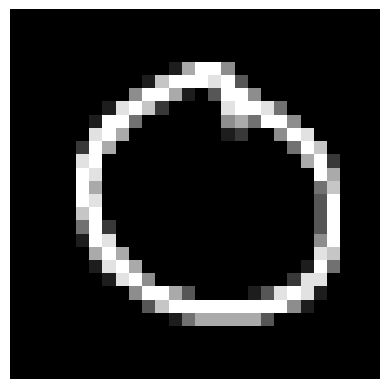

In [9]:
IDX = 42
image, label = masked_train_data[IDX]
image = image.squeeze().numpy()
plt.imshow(image, cmap='gray')
plt.axis(False)
plt.show

In [11]:
# Prepare the model
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784,128),
            nn.GELU(),
            nn.Linear(128,64),
            nn.GELU(), 
            nn.Linear(64,16),
            nn.GELU(), 
            nn.Linear(16,6)
        )

        self.decoder = nn.Sequential(
            nn.Linear(6,16),
            nn.GELU(),
            nn.Linear(16,64),
            nn.GELU(), 
            nn.Linear(64,128),
            nn.GELU(), 
            nn.Linear(128,784),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return torch.reshape(decoded, x.shape)
        

In [13]:
# Setup network
model = AutoEncoder()

In [15]:
# Evaluate BEFORE trained model
def plot_output(model, dataset, idx):
    model.eval()

    image, label = dataset[idx]
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(image.squeeze().numpy(), cmap='gray')

    with torch.inference_mode():
        output = model(image)

    axs[1].imshow(output.squeeze().numpy(), cmap='gray')

    axs[0].set_title("Input")
    axs[1].set_title("Output")

    for i in range(2):
        axs[i].axis(False)

    plt.show()

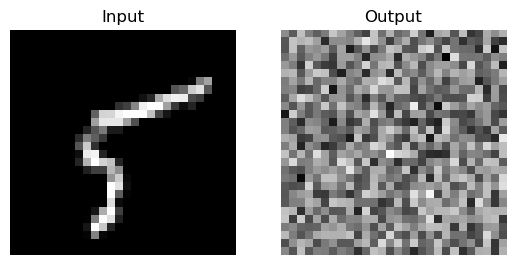

In [17]:
plot_output(model, masked_test_data, 42)

In [19]:
# 3D PLOT
def plot_encoder_output(model, dataset, num_elements = 1000):
    model.eval()

    encoded_data = []
    labels = []

    for idx in range(num_elements):
        image, label = dataset[idx]

        with torch.inference_mode():
            encoded = model.encoder(image)

        encoded_data.append(encoded.squeeze().numpy())
        labels.append(str(label))

    df = pd.DataFrame(encoded_data, columns = ['x','y','z','d', 'e', 'f',])
    df['label']= labels

    fig = px.scatter_3d(df, x='x', y='y', z='z', color=df['label'], opacity = 0.2, width = 1000, height = 1000)
    fig.show()

In [21]:
plot_encoder_output(model, masked_test_data)

  0%|          | 0/20 [00:00<?, ?it/s]

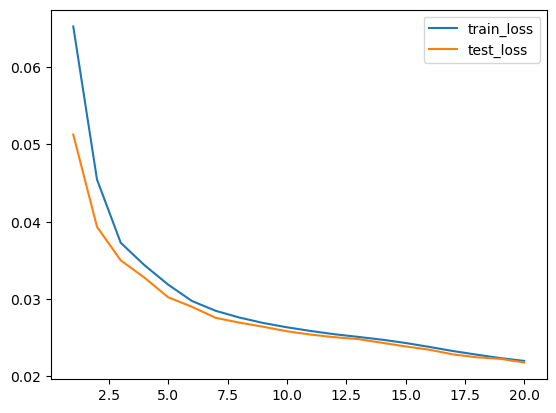

In [23]:
# Train the model
EPOCHS = 20

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

train_loss, test_loss = [], []

for epoch in tqdm(range(EPOCHS)):
    epoch_train_loss, epoch_test_loss = 0, 0
    
    # training step
    model.train()
    for batch, (X, _) in enumerate(train_dataloader):
        # Forward pass
        output = model(X)
        # Compute the loss
        loss = loss_fn(output, X)
        epoch_train_loss += loss.item()
        # Zero gradients
        optimizer.zero_grad()
        # Backpropagation
        loss.backward()
        # Optimizer
        optimizer.step()
    train_loss.append(epoch_train_loss/ len(train_dataloader))

    # test step
    model.eval()
    for batch, (X, _) in enumerate(test_dataloader):
        # Forward pass
        with torch.inference_mode():
            output = model(X)
        # Compute the loss
        loss = loss_fn(output, X)
        epoch_test_loss += loss.item()
    test_loss.append(epoch_test_loss/ len(test_dataloader))

# Computed loss plot
plt.plot(range(1, EPOCHS + 1), train_loss, label="train_loss")
plt.plot(range(1, EPOCHS + 1), test_loss, label="test_loss")
plt.legend()
plt.show()

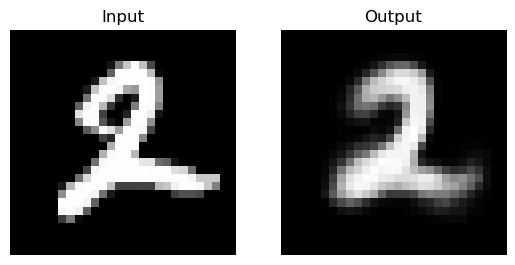

In [25]:
RANDOM_IDX = random.randint(0, len(masked_test_data) - 1)
plot_output(model, masked_test_data, RANDOM_IDX)

In [27]:
plot_encoder_output(model, masked_test_data)